In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error

fred = Fred(api_key="388e4633f23c88b89679b89794f572ed")
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

# Initial analysis


In [3]:
consumerloans_series = fred.get_series("CCLACBW027SBOG")
consumerloans_df = pd.DataFrame(consumerloans_series, columns=["consumerloans"])
consumerloans_df.index.name = "date"
# first date is 2000-06-28, last is 2024-04-10

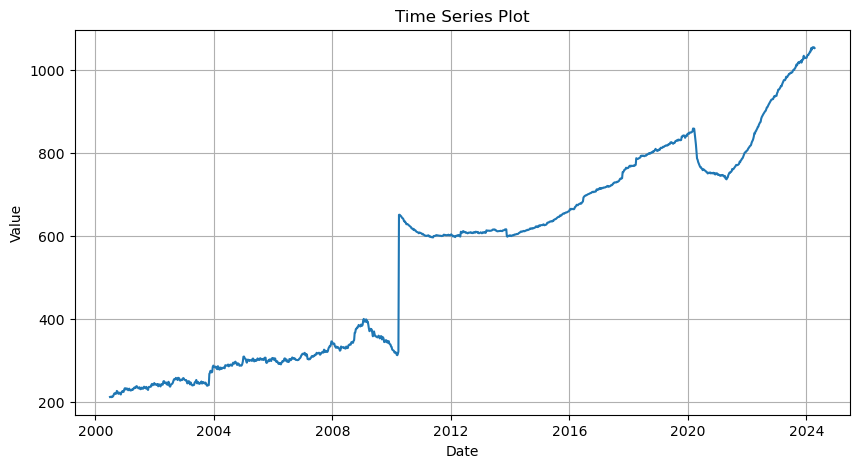

In [4]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(consumerloans_df)
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

## Adjusting for jumps


Jumps noted by fedreserve in billions

January 5, 2022 - 1.7
October 14, 2020 - 1.5
October 16, 2019 - 8.1
April 4, 2018 - 14.1
October 18, 2017 - 13.8
November 20, 2013 - -16.2
March 13, 2013 - 5.2
May 2, 2012 - 9.0
March 31, 2010 - 334.9
October 1, 2008 - 15.6
July 4, 2007 - 2.6
June 21, 2006 - -7.2
October 5, 2005 - -2.4
February 9, 2005 - -1.7
December 29, 2004 - 12.0
April 21, 2004 - -1.8
December 17, 2003 - 7.4
November 5, 2003 - 22.4
July 2, 2003 - 0.7


In [5]:
# you could either add jump amounts to prior dates or subtract from following dates to normalize. I will add to prior dates.
# Creating the jump dictionary
jumps = {
    "date": [
        "January 5, 2022",
        "October 14, 2020",
        "October 16, 2019",
        "April 4, 2018",
        "October 18, 2017",
        "November 20, 2013",
        "March 13, 2013",
        "May 2, 2012",
        "March 31, 2010",
        "October 1, 2008",
        "July 4, 2007",
        "June 21, 2006",
        "October 5, 2005",
        "February 9, 2005",
        "December 29, 2004",
        "April 21, 2004",
        "December 17, 2003",
        "November 5, 2003",
        "July 2, 2003",
    ],
    "value": [
        1.7,
        1.5,
        8.1,
        14.1,
        13.8,
        -16.2,
        5.2,
        9.0,
        334.9,
        15.6,
        2.6,
        -7.2,
        -2.4,
        -1.7,
        12.0,
        -1.8,
        7.4,
        22.4,
        0.7,
    ],
}

# Convert date strings to datetime objects
jump_df = pd.DataFrame(jumps)
jump_df["date"] = pd.to_datetime(jump_df["date"])
jump_df = jump_df.set_index("date")

consumerloans_clean = consumerloans_df.merge(
    jump_df, how="left", left_index=True, right_index=True
)
consumerloans_clean.rename(columns={"value": "jump"}, inplace=True)
consumerloans_clean["jump"] = consumerloans_clean["jump"].fillna(0)

# Adjusting jump sum for inflation with Gross domestic purchases (chain-type price index).
grossdomesticpurchases_series = fred.get_series("B712RG3Q086SBEA")
grossdomesticpurchases_df = pd.DataFrame(
    grossdomesticpurchases_series, columns=["grossdomesticpurchases"]
)
grossdomesticpurchases_df.rename_axis(index="date", inplace=True)

# Creating a DataFrame to store the cumulative jumps
cumulative_jumps = pd.DataFrame(index=consumerloans_clean.index)
cumulative_jumps["jump"] = consumerloans_clean["jump"]

# Performing an asof merge
merged_df = pd.merge_asof(
    cumulative_jumps,
    grossdomesticpurchases_df,
    left_index=True,
    right_index=True,
    direction="backward",
)  # 'backward' to take the most recent past value

# Rename the column to 'gdp_idx'
merged_df.rename(columns={"grossdomesticpurchases": "gdp_idx"}, inplace=True)

# Calculate the cumulative jumps
cumulative_jumps = merged_df.reset_index()
cumulative_jumps["cum_jump"] = 0

jump_idx = cumulative_jumps[cumulative_jumps.jump != 0].index
cumulative_jumps["cum_jump"] = cumulative_jumps.cum_jump.astype(float)
for i in jump_idx:
    denominators = cumulative_jumps.gdp_idx / cumulative_jumps.gdp_idx[i]
    cumulative_jumps.loc[: i - 1, "cum_jump"] += (
        cumulative_jumps.jump[i] * denominators[:i]
    )
    # print(max(cumulative_jumps.loc[:i, 'cum_jump'].index))
    # print(max((cumulative_jumps.jump[i] * denominators[: (i + 1)]).index))

consumerloans_clean["consumerloans"] += cumulative_jumps.set_index("date").cum_jump

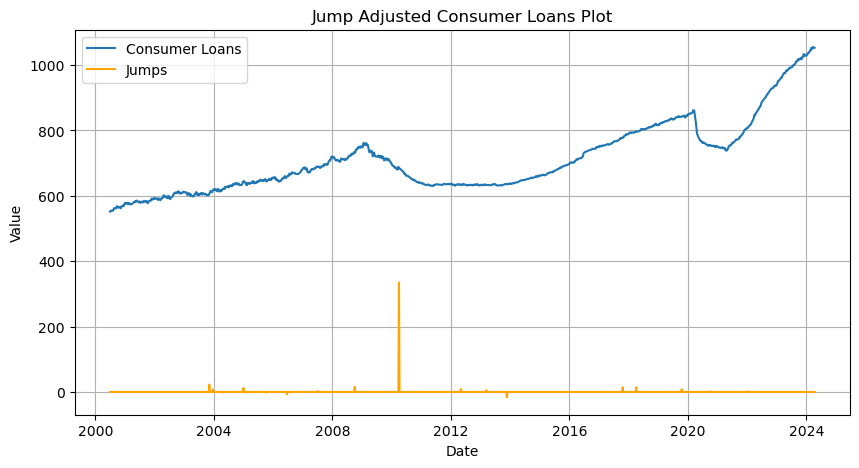

In [6]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(consumerloans_clean["consumerloans"], label="Consumer Loans")
plt.plot(consumerloans_clean["jump"], label="Jumps", color="orange")
plt.title("Jump Adjusted Consumer Loans Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## testing if variance of week-on-week difference changed after march 31, 2010


In [7]:
# Unlike Bartlett's test, which also tests for equal variances but is sensitive to departures from normality, Levene’s test is more robust against non-normal distributions.
from scipy.stats import levene

# Specify the cut-off date
cut_off_date = pd.Timestamp("2010-03-31")

# Split the data into two segments
before = consumerloans_clean[consumerloans_clean.index < cut_off_date]
after = consumerloans_clean[consumerloans_clean.index >= cut_off_date]

# Calculate week-on-week differences
diff_before = before["consumerloans"].diff().dropna()
diff_after = after["consumerloans"].diff().dropna()

# Calculate variances
var_before = diff_before.var()
var_after = diff_after.var()

# Statistical test for equality of variance
stat, p_value = levene(diff_before, diff_after)

print(f"Variance Before: {var_before}")
print(f"Variance After: {var_after}")
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

Variance Before: 8.91211618316357
Variance After: 4.931796978640383
Levene's test statistic: 65.56951319183122, p-value: 1.3315025458446714e-15


For some reason, there is significant difference before and after March 31, 2010. Assume this is because more things are accounted for in reporting after.
Will use variance after this date when finding variance of week-on-week difference.


# Forecasting


## Testing for unit root with ADF


In [8]:
from statsmodels.tsa.stattools import adfuller

# Apply the Augmented Dickey-Fuller test
result = adfuller(consumerloans_clean["consumerloans"])

print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: 0.454560
p-value: 0.983425
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


It isnt stationary, so differencing is needed.


In [9]:
consumerloans_clean["consumerloans_diff"] = consumerloans_clean["consumerloans"].diff()

cons_loans_diff = consumerloans_clean["consumerloans_diff"].dropna()

# Apply the Augmented Dickey-Fuller test
result = adfuller(cons_loans_diff)

print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -4.208595
p-value: 0.000637
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


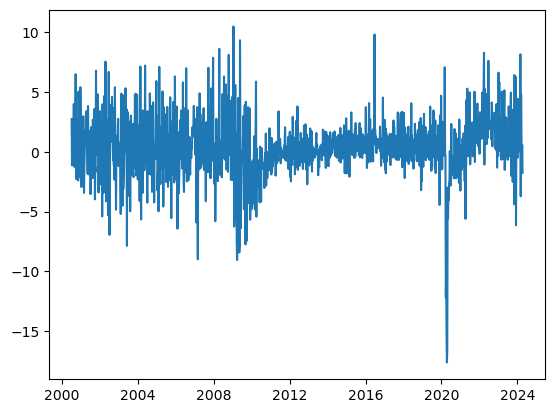

In [10]:
plt.plot(consumerloans_clean.consumerloans.diff())

Differencing once worked.


## Checking different p and q for ARMA model


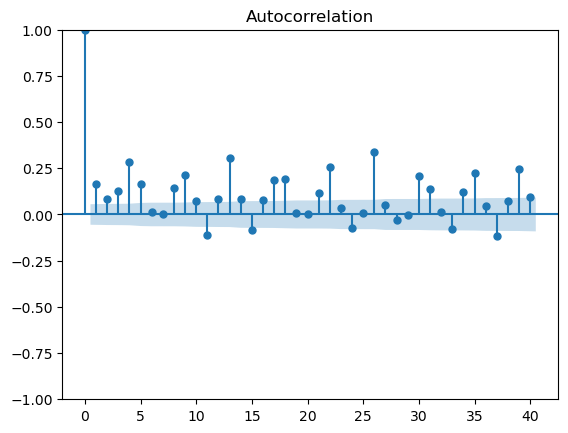

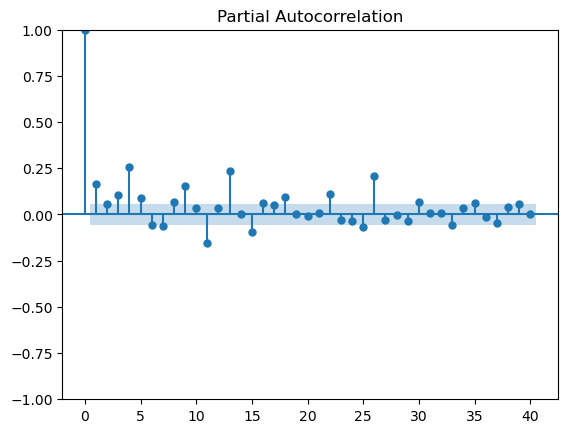

In [11]:
from statsmodels.tsa.stattools import acf, pacf

# Plot ACF and PACF
sm.graphics.tsa.plot_acf(cons_loans_diff, lags=40)
sm.graphics.tsa.plot_pacf(cons_loans_diff, lags=40)
plt.show()

I don't see much from ACF or PCF, so I will just grid search for p and q based on AIC.


In [13]:
from statsmodels.tsa.arima.model import ARIMA

max_lag = 7

# Define p and q range
p = q = range(0, max_lag, 1)  # including 20

# DataFrame to store AICs
aic_table = pd.DataFrame(index=p, columns=q)
models = pd.DataFrame(index=p, columns=q)

# Grid search
for i in tqdm(p):
    for j in q:
        # try:
        model = ARIMA(
            consumerloans_clean.consumerloans, order=(i, 1, j)
        )  # Assuming timeseries is stationary
        results = model.fit()
        aic_table.loc[i, j] = results.aic
        models.loc[i, j] = results
        # except Exception as e:
        #     aic_table.loc[i, j] = np.nan
        #     print(f"Failed to fit ARMA({i},{j}): {e}")

# Find the best model
aic_table = aic_table.astype(float)
min_aic = aic_table.min().min()
best_params = aic_table.stack().idxmin()
print(f"Best ARMA model: ARMA{best_params} with AIC: {min_aic}")

# Display the AIC table
# print(aic_table)

# Optional: Highlight the best model directly if using Jupyter Notebook or similar environment
# aic_table.style.applymap(lambda x: 'background-color: yellow' if x == min_aic else '')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:21<00:00, 11.61s/it]

Best ARMA model: ARMA(6, 4) with AIC: 5555.51679888438


<AxesSubplot: xlabel='date'>

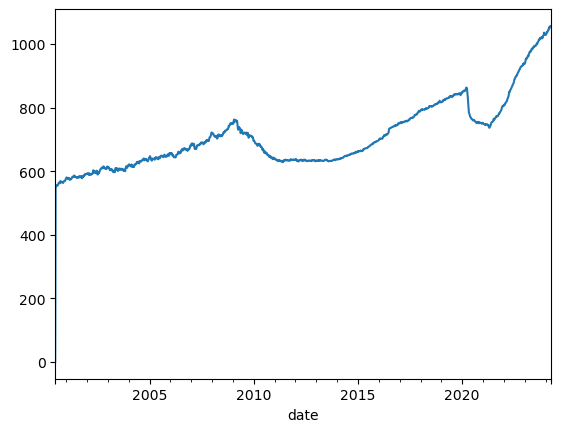

In [15]:
models.loc[best_params].fittedvalues.plot()

## Plotting to see what ARIMA model looks like


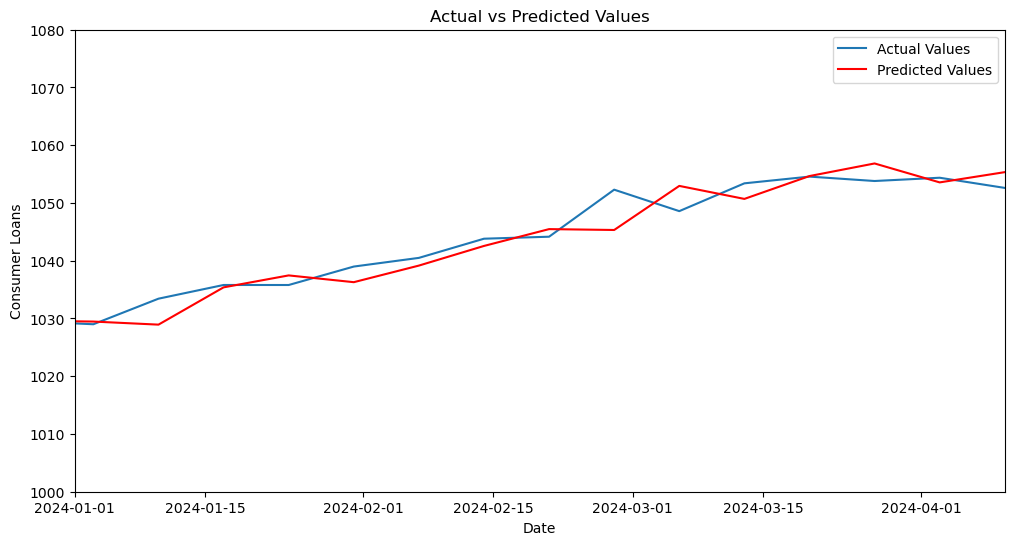

In [16]:
import matplotlib.dates as mdates

# Get the in-sample predictions
model = models.loc[best_params]
predictions = model.predict(
    start=model.fittedvalues.index[0], end=model.fittedvalues.index[-1], dynamic=False
)
actual = consumerloans_clean["consumerloans"][
    1:
]  # adjust indexing based on differencing (d=1)

start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-04-10")

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual, label="Actual Values")
plt.plot(predictions.index, predictions, color="red", label="Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Consumer Loans")
plt.gca().set_xlim([start_date, end_date])
plt.ylim(1000, 1080)
plt.legend()
plt.show()

In [17]:
# Get one-step-ahead forecast
one_step_forecast = model.get_prediction(start=end_date, end=end_date)
forecast_mean = one_step_forecast.predicted_mean
forecast_conf_int = one_step_forecast.conf_int()

# Print the results
print("One-step-ahead Forecast (Predicted Mean):")
print(forecast_mean)

print("\nForecast Confidence Interval:")
print(forecast_conf_int)
print(f"last value: {consumerloans_clean['consumerloans'][-1]}")

One-step-ahead Forecast (Predicted Mean):
2024-04-10    1055.338091
Freq: W-WED, dtype: float64

Forecast Confidence Interval:
            lower consumerloans  upper consumerloans
2024-04-10          1050.885055          1059.791127
last value: 1052.6077


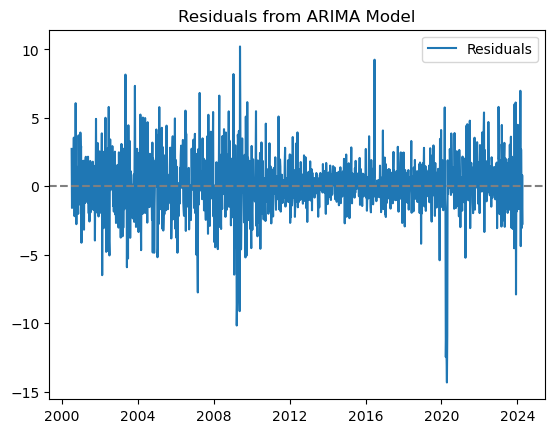

In [18]:
# Calculating residuals
residuals = actual - predictions
residuals = residuals.dropna()
# Plotting the residuals
plt.plot(residuals, label="Residuals")
plt.title("Residuals from ARIMA Model")
plt.axhline(y=0, linestyle="--", color="gray")
plt.legend()
plt.show()

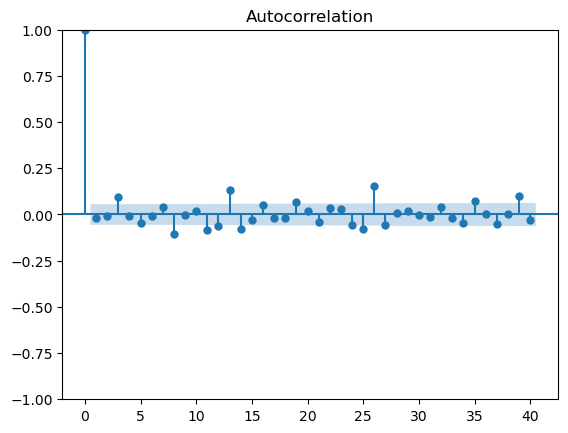

In [19]:
# Plot acf of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

Residuals seem like white noise?


# Trying exogenous variables


In [34]:
"""
Consumer spending
Unemployment
Inflation
Fed funds rate
Average Credit Card APR
"""

retail_sales = fred.get_series("RSXFS")  # Monthly
inflation = fred.get_series("B712RG3Q086SBEA")  # Quarterly
unemployment = fred.get_series("UNRATE")  # Monthly
fedfunds = fred.get_series("FEDFUNDS")  # Monthly
apr = fred.get_series("TERMCBCCALLNS")  # Quarterly
exog1 = pd.DataFrame(
    {
        "retail_sales": retail_sales,
        "inflation": inflation,
        "unemployment": unemployment,
        "fedfunds": fedfunds,
        "apr": apr,
    }
)

loans = consumerloans_clean.consumerloans  # Weekly

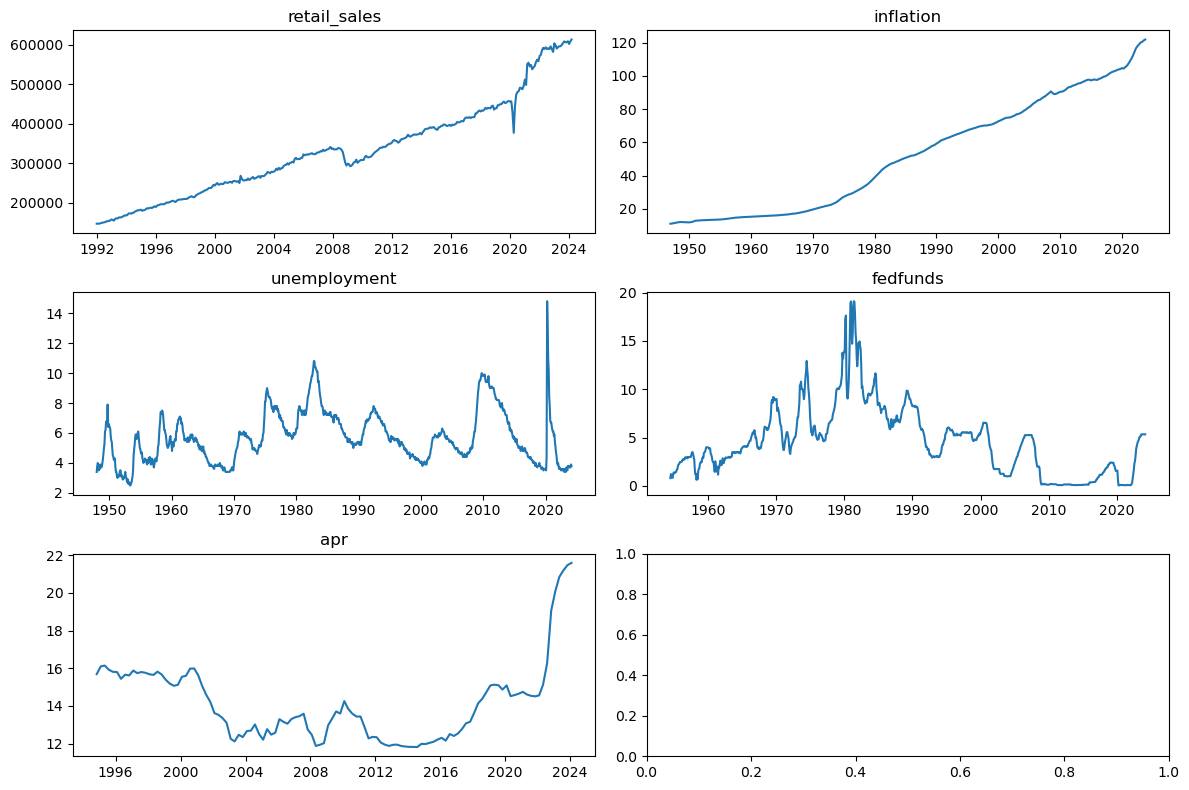

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i, e in enumerate(exog1.columns):
    axs[i // 2, i % 2].plot(exog1[e].dropna().index, exog1[e].dropna())
    axs[i // 2, i % 2].set_title(e)

plt.tight_layout()

From the above plots, it looks like the exogenous series are largely already clean. However, it appears retail_sales and inflation are nonstationary. Will consider the differenced series below.


Text(0.5, 1.0, 'Differenced Inflation')

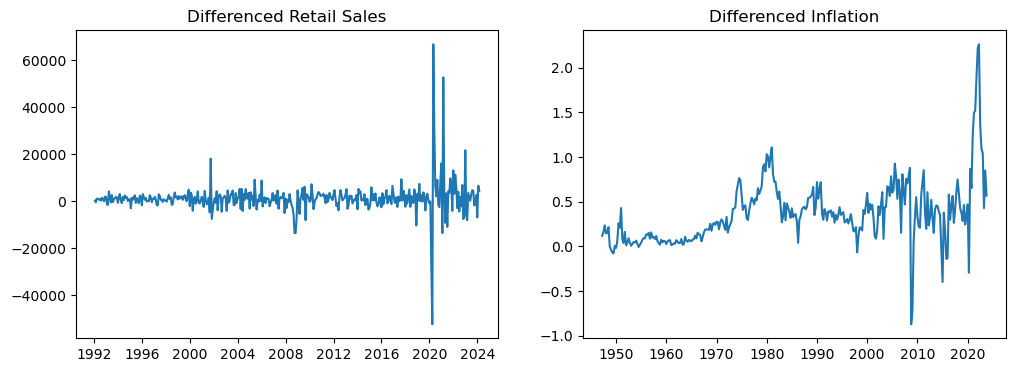

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(retail_sales.diff())
axs[0].set_title("Differenced Retail Sales")
axs[1].plot(inflation.diff())
axs[1].set_title("Differenced Inflation")

The exogenous variables have different frequencies. We will address this by applying linear interpolation over time to fill the missing dates.


In [60]:
exog1 = exog1.interpolate(method="time", limit_direction="both")

In [83]:
exog1.resample("W").interpolate(method="time", limit_direction="both")

,retail_sales,inflation,unemployment,fedfunds,apr
1947-01-05,146925.0,11.724758,3.8,0.80,15.690000
1947-01-12,146925.0,11.724758,3.8,0.80,15.690000
1947-01-19,146925.0,11.724758,3.8,0.80,15.690000
1947-01-26,146925.0,11.724758,3.8,0.80,15.690000
1947-02-02,146925.0,11.724758,3.8,0.80,15.690000
...,...,...,...,...,...
2024-02-04,606596.0,121.863000,3.8,5.33,21.375652
2024-02-11,606596.0,121.863000,3.8,5.33,21.375652
2024-02-18,606596.0,121.863000,3.8,5.33,21.375652
2024-02-25,606596.0,121.863000,3.8,5.33,21.375652


It appears that the series above only extend to March 3, 2024 at the latest. Although there may be predictive power when using the observations on past data, it is unlikely these results will materially improve a forecast in May. We will instead consider the following weekly series.


In [84]:
claims = fred.get_series("ICSA")  # Weekly
eff_funds = fred.get_series("FF")  # Weekly
deposits = fred.get_series("DPSACBW027SBOG")  # Weekly

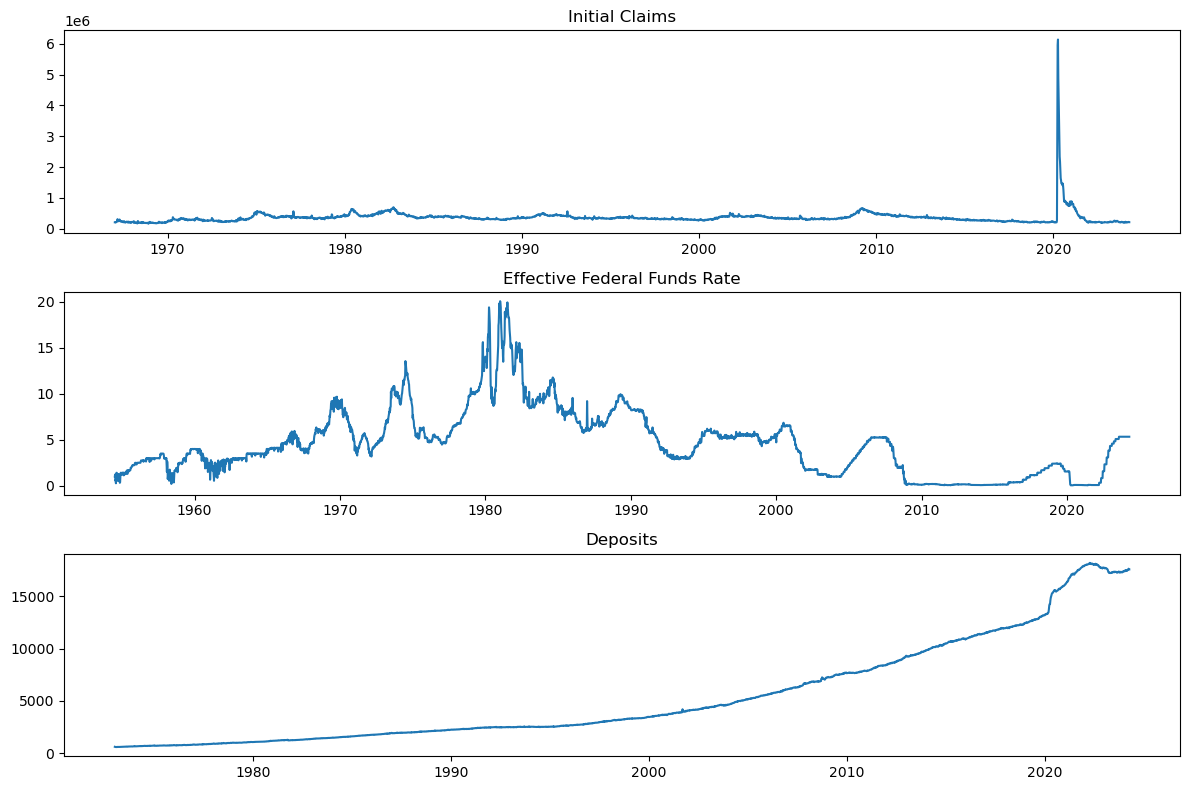

In [86]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].plot(claims)
axs[0].set_title("Initial Claims")
axs[1].plot(eff_funds)
axs[1].set_title("Effective Federal Funds Rate")
axs[2].plot(deposits)
axs[2].set_title("Deposits")
fig.tight_layout()

Text(0.5, 1.0, 'Log Deposits')

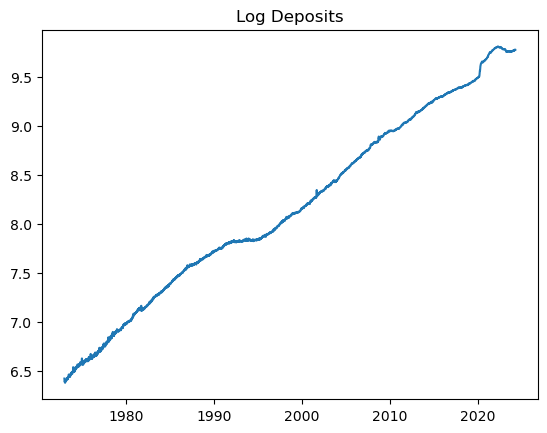

In [88]:
plt.plot(np.log(deposits))
plt.title("Log Deposits")

Log deposits appear to be linear. Will difference this series to use in model.


In [107]:
exog = pd.DataFrame(
    {"claims": claims, "eff_funds": eff_funds, "deposits": deposits}
).interpolate(method="time", limit_direction="both")
exog["deposits_log_ret"] = np.log(exog.deposits).diff()

In [111]:
arimax_df = pd.merge_asof(
    consumerloans_clean.consumerloans,
    exog,
    left_index=True,
    right_index=True,
    direction="backward",
)

In [112]:
arimax_df

,consumerloans,claims,eff_funds,deposits,deposits_log_ret
date,,,,,
2000-06-28,551.643510,287428.571429,6.53,3576.1524,-0.004626
2000-07-05,554.377885,287857.142857,6.85,3625.4808,0.007805
2000-07-12,553.241385,298714.285714,6.44,3613.4882,-0.001895
2000-07-19,554.903785,301285.714286,6.50,3619.9306,0.001017
2000-07-26,554.138385,298857.142857,6.50,3639.3521,0.003054
...,...,...,...,...,...
2024-03-13,1053.400000,212000.000000,5.33,17535.5968,0.001353
2024-03-20,1054.565700,212000.000000,5.33,17568.9661,0.001086
2024-03-27,1053.803300,217714.285714,5.33,17645.4336,0.002479


In [179]:
arimax_models = np.empty((len(p), len(q)), dtype=object)
arimax_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arimax = ARIMA(
            arimax_df.consumerloans,
            order=(ar_lags, 1, ma_lags),
            exog=arimax_df.drop(columns=["consumerloans", "deposits"]).shift().bfill(),
        )
        arimax_models[ar_lags,ma_lags] = arimax
        arimax_results[ar_lags,ma_lags] = arimax.fit()
arimax_aics = np.array(list(map(lambda r: r.aic, arimax_results.flatten()))).reshape(len(p), len(q))
arimax_aics = pd.DataFrame(arimax_aics, index=p, columns=q)

100%|██████████| 7/7 [01:30<00:00, 12.98s/it]


<AxesSubplot: >

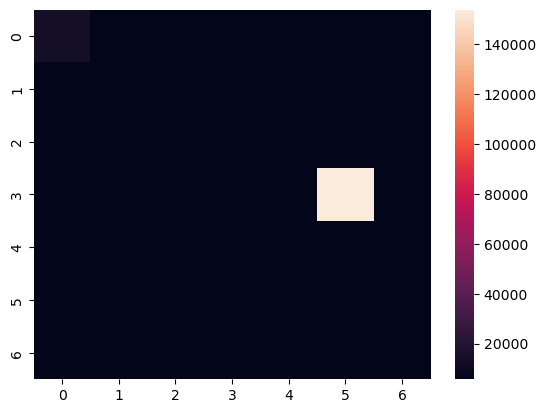

In [182]:
sns.heatmap(arimax_aics)

In [183]:
arimax_best_params = arimax_aics.stack().idxmin()

In [176]:
print(mean_squared_error(arimax_df.consumerloans, arimax_results[arimax_best_params].fittedvalues))
print(mean_squared_error(
    consumerloans_clean.consumerloans, models.loc[best_params].fittedvalues
))

240.46253568420556
250.06672166468647


In [ ]:
arimax_results[arimax_best_params].predicted

In [194]:
deposits.name = 'deposits'
eff_funds.name= 'eff_funds'

In [192]:
pd.merge_asof(consumerloans_clean.consumerloans, deposits, left_index=True, right_index=True, direction='backward')

,consumerloans,deposits
date,,
2000-06-28,551.643510,3576.1524
2000-07-05,554.377885,3625.4808
2000-07-12,553.241385,3613.4882
2000-07-19,554.903785,3619.9306
2000-07-26,554.138385,3639.3521
...,...,...
2024-03-13,1053.400000,17535.5968
2024-03-20,1054.565700,17568.9661
2024-03-27,1053.803300,17645.4336


In [ ]:
arimax_df[['eff_funds', 'deposits'] + '_shifted'] = arimax_df[['eff_funds', 'deposits']].shift()

TypeError: can only concatenate list (not "str") to list

TypeError: can only concatenate list (not "str") to list

In [ ]:
arimax_df